# <font style="color:blue">Train a Custom Object Detector using DarkNet YOLOv4</font>
In this notebook, we will train a YOLOv4 object detector to detect faces with and without mask. We will use DarkNet framework.

The training and test images come from the Kaggle dataset.

# <font style="color:blue">Change Runtime Type</font>
Before proceeding, make sure that the notebook is running on the GPU. Go to Runtime -> Change runtime type -> Select hardware Accelerator as GPU.

# <font style="color:blue">1. Link Google Drive</font>
Since it will take considerable amount of time to train the network, it is mendatory to link your Google Drive with Colab so that everything is backed up. So, if the runtime gets disconnected in the middle of something, you can simply re-link the drive and start working. To link drive, just run the cell below and follow the 2 steps.

1. It will generate a link. Click on the link to login to your google account
1. Get the authorization code and paste it in the box under the cell.

In [1]:
import os

if not (os.path.isdir('/content/drive/My Drive')):
    try:
        from google.colab import drive
        drive.mount('/content/drive')

        if not (os.path.isdir('/content/drive/My Drive/FaceMaskDetector_YOLOv4')):
            %mkdir '/content/drive/My Drive/FaceMaskDetector_YOLOv4'

        %cd /content/drive/My\ Drive/FaceMaskDetector_YOLOv4

    except ImportError as e:
        pass  # module doesn't exist, deal with it.
    
else:
    %cd /content/drive/My\ Drive/FaceMaskDetector_YOLOv4

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/FaceMaskDetector_YOLOv4


# <font style="color:blue">2. Clone and build the DarkNet Repository </font>
We will use Alexey's darknet fork which has many modifications and improvements and is actively maintained by him.
Before building, we will make some changes to the Makefile. Specifically, we will enable the following:
1. Build darknet with OpenCV
1. Build with CUDA enabled
1. Build with cuDNN enabled.

If darknet is already present, then we just make the darknet binary executable.

In [0]:
if not (os.path.isdir("darknet")):
    !git clone https://github.com/AlexeyAB/darknet.git

    %cd darknet

    !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
    !sed -i 's/GPU=0/GPU=1/' Makefile
    !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
    
    print("Building. . . It might take 2-3 minutes")
    
    !make &> build_log.txt

    %cd ..
else:
    !chmod ugo+x ./darknet/darknet

# <font style="color:blue">3. Download Data</font>
Given below is the script for downloading data from dropbox.

It is a zip archive containing a set of images and for each image, a text file containing the face location along with the class it corespond to (mask or no mask).

The class 0 is for faces with mask and the class 1 is for faces without mask.

The first field object-class-id is an integer representing the class of the object. It ranges from 0 to (number of classes – 1). In our current case, since we have only one class of snowman, it is always set to 0.

The second and third entry, center-x and center-y are respectively the x and y coordinates of the center of the bounding box, normalized (divided) by the image width and height respectively.

The fourth and fifth entry, width and height are respectively the width and height of the bounding box, again normalized (divided) by the image width and height respectively.

Let’s consider an example with the following notations:
```
x – x-coordinate(in pixels) of the center of the bounding box
y – y-coordinate(in pixels) of the center of the bounding box
w – width(in pixels) of the bounding box
h – height(in pixels) of the bounding box
W – width(in pixels) of the whole image
H – height(in pixels) of the whole image
```
Then we compute the annotation values in the label files as follows:
```
center-x = x / W
center-y = y / H
width = w / W
height = h / H
```
The above four entries are all floating point values between 0 to 1.

Note that the 2nd and 3rd elements are centers and NOT the top/bottom left corners. This is different from most datasets available on the internet. 

Thus, we reformat the bounding boxes according to YOLO in the last line of code in the function below.

**NOTE:** Downloading the data from aws takes considerable amount of time ( ~7 seconds per image ). Thus, we have provided a zip file for the dataset which you can download in the next cell. You can use the script to download other classes when you experiment further.

In [0]:
classes = ["Mask", "No-Mask"]

## <font style="color:blue">3.1. Download Data</font>
Download the data which we have shared using the dropbox link.

The code below also sanitize the file names as darknet cannot work with filename containing image file extensions within their names excluding the extension. For exemple "a_.jpeg_image.jpeg" would not be loaded by darknet.

In [0]:
if not (os.path.isdir("kaggle_and_no-mask_dataset")):
    %mkdir kaggle_and_no-mask_dataset

    %cd kaggle_and_no-mask_dataset

    !wget "https://www.dropbox.com/s/6gewe947ake1g95/kaggle_and_no-mask_dataset.zip?dl=1" -O kaggle_and_no-mask_dataset.zip
    !unzip kaggle_and_no-mask_dataset.zip &> /dev/null

    %rm kaggle_and_no-mask_dataset.zip
    
    %cd ..


    # sanitize filenames to prevent darknet not being able to load some files
    dataset_dir = "kaggle_and_no-mask_dataset"
    files = os.listdir(dataset_dir)

    for fullfilename in files:
        fname = fullfilename[0:fullfilename.rfind(".")]
        fext = fullfilename[fullfilename.rfind("."):]

        if (fname.find(".jpg") > -1):
            fname = fname.replace(".jpg", "")

            newname = dataset_dir + "/" + fname + fext

            os.rename(dataset_dir + "/" + fullfilename, dataset_dir + "/" + fname + fext)

## <font style="color:blue">3.2. Prepare dataset files</font>
We need to create a txt file which contains the path to the images. These files will be used while setting up the training. 

The data is split into train and test in the ratio of 80:20. So, we will use 80% of the data for training and the rest for testing after a few iterations of training.

In [0]:
import random
import subprocess
import sys

image_dir = "./kaggle_and_no-mask_dataset"
f_val = open("data_test.txt", 'w')
f_train = open("data_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = int(len(files) / 2)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

#print("test_array={} - {}\ndata_size={}\ndata_test_size={}".format(len(test_array), test_array, data_size, data_test_size))

for f in os.listdir(image_dir):
    ext = f.split(".")[-1]
    if(ext == "jpg") or (ext == "jpeg") or (ext == "png"):
        ind += 1
        
        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

# <font style="color:blue">4. Download Code for YOLO Training</font>
We have shared the code for training in the link below. Explanation of each file follows next.

In [0]:
if not (os.path.exists("yolov4-facemask-setup.data")):
    !wget "https://gitlab.com/aniki/yolo_darknet_facemask_detector/-/raw/master/YOLOv4/yolov4-facemask-code.zip?inline=false" -O yolov4-facemask-code.zip
    !unzip -o yolov4-facemask-code.zip

    %rm yolov4-facemask-code.zip

You can see there are 4 files which have been downloaded. We will go through each file in the next section.

# <font style="color:blue">5. Download weights for Convolutional backbone</font>
When you train your own object detector, it is a good idea to leverage existing models trained on very large datasets even though the large dataset may not contain the object you are trying to detect. This process is called transfer learning.

Instead of learning from scratch, we use a pre-trained model which contains convolutional weights trained on ImageNet. Using these weights as our starting weights, our network can learn faster. We will use the pre-trained convolutional backbone. 

We will download the weights file from our server as the author's server seemed slow. If you face any issues, you can download the file from the link given in the code below.

In [0]:
if not (os.path.exists("yolov4.conv.137")):
    # Original file: https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137
    !wget "https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137" -O yolov4.conv.137
    # this link seems to not work...
    #!wget "https://drive.google.com/open?id=1JKF-bdIklxOOVy-2Cr5qdvjgGpmGfcbp" -O yolov4.conv.137

# <font style="color:blue">6. Training Configuration</font>
As explained in the theory section, we will use the config file to specify the various training parameters. A gist of all the parameters is given below:

## <font style="color:blue">6.1. Data Setup</font>
In the file **`yolov4-facemask-setup.data`**(included within this notebook), we need to provide information about the specifications for our object detector and some relevant paths.

The contents of the file are as follows:
```
classes = 2
train  = data_train.txt
valid  = data_test.txt
names = class.names
backup = backup/
```
The classes parameter represents the number of classes. In our case, it is 2.

You need to provide the absolute paths of the files **`data_train.txt`** and **`data_test.txt`** generated earlier, which have the list of files to be used for training(train parameter) and validation(valid parameter) respectively.

The names field represents the path of a file which contains the names of all the classes. We have included the **`class.names`** file which contains the class name **`No-Mask`** and **`Mask`**. You will need to provide its absolute path in your machine here.

Lastly, for the **`backup`** parameter, we need to give the path to an existing directory where we can store the intermediate weights files as the training progresses.

## <font style="color:blue">6.2. Training Config File</font>
Along with the yolov4-facemask-setup.data and class.names files, YOLOv4 also needs a configuration file **`yolov4-facemask-train.cfg`**. It is based on the demo configuration file, yolov4-custom.cfg (comes with darknet code). All the important training parameters are stored in this configuration file. Let us understand what they mean and what values to set them to.

### <font style="color:green">6.2.1 Batch hyper-parameter in YOLOv4</font>
Let’s learn more about batch and subdivision parameter.
```
[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=64
subdivisions=32
```
The batch parameter indicates the batch size used during training.

Our training set contains a few hundred images, but it is not uncommon to train on million of images. The training process involves iteratively updating the weights of the neural network based on how many mistakes it is making on the training dataset.

It is impractical (and unnecessary) to use all images in the training set at once to update the weights. So, a small subset of images is used in one iteration, and this subset is called the batch size.

When the batch size is set to 64, it means 64 images are used in one iteration to update the parameters of the neural network.

### <font style="color:green">6.2.2 Subdivisions configuration parameter in YOLOv4</font>
Even though you may want to use a batch size of 64 for training your neural network, you may not have a GPU with enough memory to use a batch size of 64. Fortunately, Darknet allows you to specify a variable called subdivisions that lets you process a fraction of the batch size at one time on your GPU.

You can start the training with subdivisions=1, and if you get an Out of memory error, increase the subdivisions parameter by multiples of 2 (e.g. 2, 4, 8, 16) untill the training proceeds successfully. The GPU will process batch/subdivision number of images at a time, but the full batch or iteration would be complete only after all the 64 (as set above) images are processed.

During testing, both batch and subdivision are set to 1.

### <font style="color:green">6.2.3 Width, Height, Channels</font>
These configuration parameters specify the input image size and the number of channels.

```
width=416
height=416
channels=3
```
The input training images are first resized to width x height before training. Here we use the default values of 416×416. The results might improve if we increase it to 608×608, but it would take longer to train too. channels=3 indicates that we would be processing 3-channel RGB input images.

### <font style="color:green">6.2.4 Momentum and Decay</font>
The configuration file contains a few parameters that control how the weight is updated.
```
momentum=0.9
decay=0.0005
```
In the previous section, we mentioned how the weights of a neural network are updated based on a small batch of images and not the entire dataset. Because of this reason, the weight updates fluctuate quite a bit. That is why a parameter momentum is used to penalize large weight changes between iterations.

A typical neural network has millions of weights and therefore they can easily overfit any training data. Overfitting simply means it will do very well on training data and poorly on test data. It is almost like the neural network has memorized the answer to all images in the training set, but really not learned the underlying concept. One of the ways to mitigate this problem is to penalize large value for weights. The parameter decay controls this penalty term. The default value works just fine, but you may want to tweak this if you notice overfitting.

### <font style="color:green">6.2.5 Learning Rate, Steps, Scales, Burn In (warm-up)</font>
```
learning_rate=0.001
policy=steps
steps=8000,9000
scales=.1,.1
burn_in=100
```
The parameter learning rate controls how aggressively we should learn based on the current batch of data. Typically this is a number between 0.01 and 0.0001.

At the beginning of the training process, we are starting with zero information and so the learning rate needs to be high. But as the neural network sees a lot of data, the weights need to change less aggressively. In other words, the learning rate needs to be decreased over time. In the configuration file, this decrease in learning rate is accomplished by first specifying that our learning rate decreasing policy is steps. In the above example, the learning rate will start from 0.001 and remain constant for 8000 iterations, and then it will multiply by scales (0.1) to get the new learning rate. A second step is set at 9000 iterations. Again, the learning rate will be multiplied by scale (still 0.1).

In the previous paragraph, we mentioned that the learning rate needs to be high in the beginning and low later on. While that statement is largely true, it has been empirically found that the training speed tends to increase if we have a lower learning rate for a short period of time at the very beginning. This is controlled by the burn_in parameter. Sometimes this **`burn-in`** period is also called warm-up period.

### <font style="color:green">6.2.6 Data augmentation</font>
We know data collection takes a long time and it is difficult to find high quality annotated data. We want to make maximum use of this data by cooking up new data. This process is called data augmentation. For example, an image of the ambulance rotated by 5 degrees is still an image of a ambulance. The angle parameter in the configuration file allows you to randomly rotate the given image by ± angle.

Similarly, if we transform the colors of the entire picture using saturation, exposure, and hue, it is still a picture of the ambulance.
```
angle=0
saturation = 1.5
exposure = 1.5
hue=.1
```
We used the default values for training.

### <font style="color:green">6.2.7 Number of iterations</font>
Finally, we need to specify how many iterations should the training process be run for.
```
max_batches=10000
```

For multi-class object detectors, the max_batches number is higher, i.e. we need to run for more number of batches (e.g. in yolov3-voc.cfg). For an n-classes object detector, it is advisable to run the training for at least 2000*n batches. In our case, 10000 iterations provide a good training. 

# <font style="color:blue">7. Start Training </font>
For starting training using darknet, we need to execute the following command. Here we are specifying the
1. path to the setup file, 
1. path to config file, 
1. path to convolutional weights file 

and also passing some flags such as:

- **`dont_show`** which wont display the graphs. This is required for Colab since it does not have a display and it will crash if it tries to display, not if you run the notebook on your local system.
- **`map`** - this will calculate mAP - mean average precision for the test data which we have specified using the data_test.txt file which contains 20% of our data.

In [0]:
if not (os.path.exists("/content/drive/My Drive/FaceMaskDetector_YOLOv4/backup/yolov4-facemask-train_last.weights")):
    # start the training from the begining
    !./darknet/darknet detector train yolov4-facemask-setup.data yolov4-facemask-train.cfg ./yolov4.conv.137 -dont_show -map 2> train_log.txt
else:
    # resume training where we stopped
    !./darknet/darknet detector train yolov4-facemask-setup.data yolov4-facemask-train.cfg ./backup/yolov4-facemask-train_last.weights -dont_show -map 2> train_log.txt

# <font style="color:blue">Notes on Training</font>
From the above training process we can make the following observations:
1. The training of YOLOv4 takes longer than YOLOv3.
1. We can see that the mAP is already pretty good even at the very begining of the training compared to YOLOv3, which needed a lot of training before reaching even only 60%.
1. At the end of the training, we reached an accuracy of 90% with 10,000 iterations.

## <font style="color:blue">Download our trained weights</font>
You can download our weights which we trained using the link below.

In [0]:
#!wget "https://www.dropbox.com/s/qeno1qc1habd03d/yolov3-ambulance_last.weights?dl=1" -O yolov3-ambulance.weights

# <font style="color:blue">8. Perform Inference</font>
Finally, let us use the trained model to perform inference on some unseen images from the internet.

Below is a simple utility function which can be used to display the input and output.

In [0]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("predictions.jpg")

    plt.figure(figsize=[20,8])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")
    plt.show()

### <font style="color:green">8.1. Test Image 1</font>

In [0]:
# download test image 1 if not already present
if not (os.path.exists("test-image1.jpg")):
    !wget "https://www.dropbox.com/s/fxei8rit9v2n83s/test-image1.jpg?dl=1" -O test-image1.jpg

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
Cannot load image data/labels/32_0.png
Cannot load image data/labels/33_0.png
Cannot load image data/labels/34_0.png
Cannot load image data/labels/35_0.png
Cannot load image data/labels/36_0.png
Cannot load image data/labels/37_0.png
Cannot load image data/labels/38_0.png
Cannot load image data/labels/39_0.png
Cannot load image data/labels/40_0.png
Cannot load image data/labels/41_0.png
Cannot load image data/labels/42_0.png
Cannot load image data/labels/43_0.png
Cannot load image data/labels/44_0.png
Cannot load image data/labels/45_0.png
Cannot load image data/labels/46_0.png
Cannot load image data/labels/47_0.png
Cannot load image data/labels/48_0.png
Cannot load image data/labels/49_0.png
Cannot load image data/labels/50_0.png
Cannot load image data/labels/51_0.png
Cannot load image data/labels/52_0.png
Cannot load image data/labels/53_0.png
Cannot load image data/labels/54_0.png
Cannot load image dat

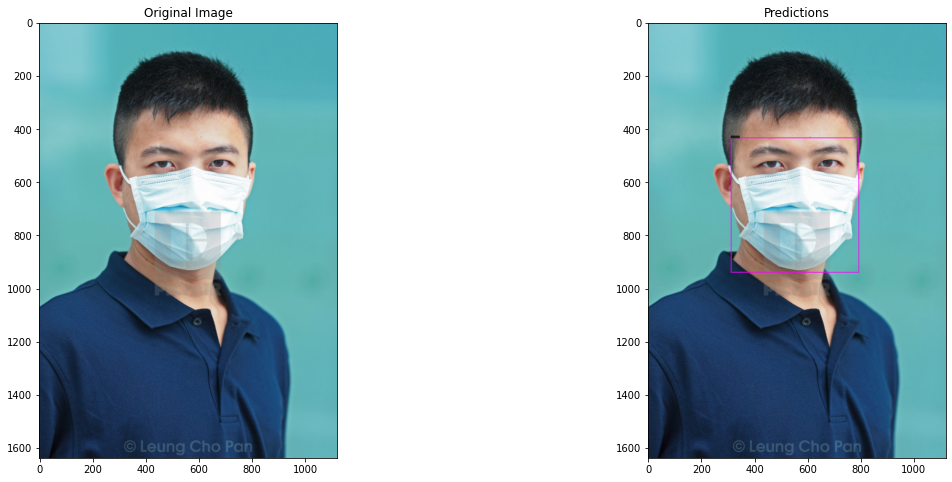

In [5]:
# perform inference
!./darknet/darknet detector test yolov4-facemask-setup.data yolov4-facemask-test.cfg backup/yolov4-facemask-train_final.weights test-image1.jpg -thresh .6

# display the result
display_output("test-image1.jpg")

# rename output file
%mv "predictions.jpg" "test-image1-out.jpg"

### <font style="color:green">8.2. Test Image 2</font>

In [0]:
# download test image 2 if not already present
if not (os.path.exists("test-image2.jpg")):
    !wget "https://www.dropbox.com/s/ia1fijzr69ytpp1/test-image2.jpg?dl=1" -O test-image2.jpg

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 

 seen 64, trained: 640 K-images (10 Kilo-batches_64) 
test-image2.jpg: Predicted in 101.143000 milli-seconds.
Mask: 100%
Mask: 100%
Mask: 86%
No-Mask: 100%
Mask: 100%


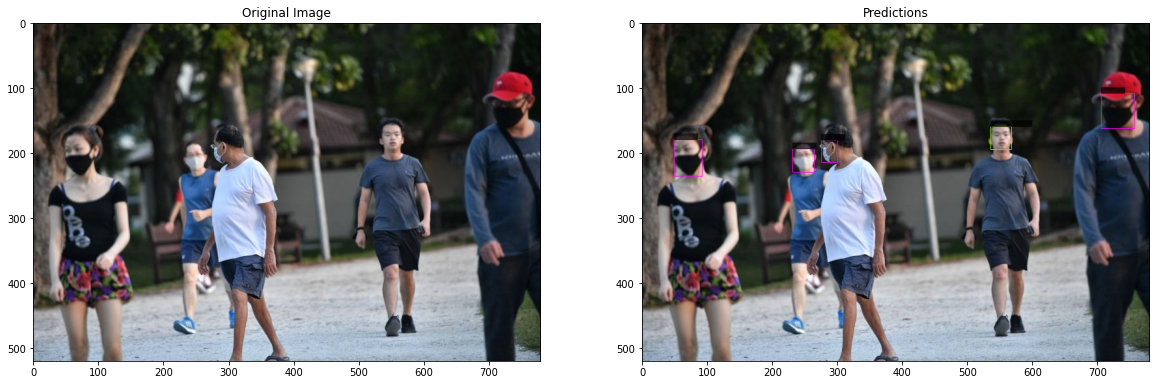

In [7]:
# perform inference
!./darknet/darknet detector test yolov4-facemask-setup.data yolov4-facemask-test.cfg backup/yolov4-facemask-train_final.weights test-image2.jpg -thresh .6  2> /dev/null

#display the result
display_output("test-image2.jpg")

# rename output file
%mv "predictions.jpg" "test-image2-out.jpg"

### <font style="color:green">8.3. Test Image 3</font>

In [0]:
# download test image 3 if not already present
if not (os.path.exists("test-image3.jpg")):
    !wget "https://www.dropbox.com/s/g905k4r1git5kbx/test-image3.jpg?dl=1" -O test-image3.jpg

In [9]:
# perform inference
!./darknet/darknet detector test yolov4-facemask-setup.data yolov4-facemask-test.cfg backup/yolov4-facemask-train_final.weights test-image3.jpg -thresh .6  2> /dev/null

#display the result
display_output("test-image3.jpg")

# rename output file
%mv "predictions.jpg" "test-image3-out.jpg"

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 

 seen 64, trained: 640 K-images (10 Kilo-batches_64) 
test-image3.jpg: Predicted in 100.939000 milli-seconds.
Mask: 100%
Mask: 99%
Mask: 100%
No-Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 100%
Mask: 99%
Mask: 100%
Mask: 100%


### <font style="color:green">8.4. Test Image 4</font>

In [0]:
# download test image 4 if not already present
if not (os.path.exists("test-image4.jpg")):
    !wget "https://www.dropbox.com/s/90ggmiur7b8g35m/test-image4.jpg?dl=1" -O test-image4.jpg

net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 
nms_kind: greedynms (1), beta = 0.600000 

 seen 64, trained: 640 K-images (10 Kilo-batches_64) 
test-image4.jpg: Predicted in 100.611000 milli-seconds.
No-Mask: 99%
No-Mask: 90%
Mask: 100%
Mask: 79%
Mask: 100%
No-Mask: 99%
Mask: 100%
No-Mask: 95%
Mask: 100%


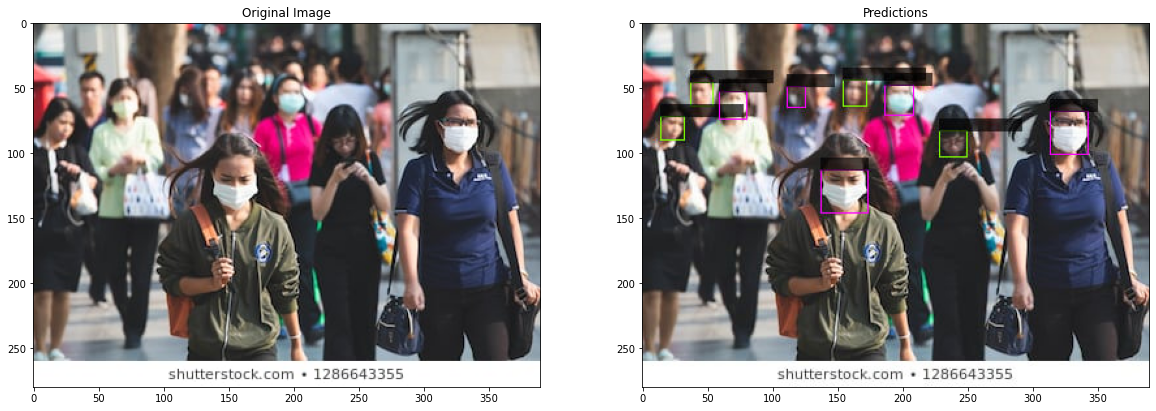

In [11]:
# perform inference
!./darknet/darknet detector test yolov4-facemask-setup.data yolov4-facemask-test.cfg backup/yolov4-facemask-train_final.weights test-image4.jpg -thresh .6 2> /dev/null

#display the result
display_output("test-image4.jpg")

# rename output file
%mv "predictions.jpg" "test-image4-out.jpg"

### <font style="color:green">8.5. Test Video 1</font>

In [0]:
if not (os.path.exists("test-video1.mp4")):
    !wget "https://www.dropbox.com/s/pds0w3z5y7w89oz/test-video1.mp4?dl=1" -O test-video1.mp4

In [13]:
!rm out-vid1.avi

!./darknet/darknet detector demo yolov4-facemask-setup.data yolov4-facemask-test.cfg backup/yolov4-facemask-train_final.weights test-video1.mp4 -thresh .6 -out_filename out-vid1.avi -dont_show

Streaming output truncated to the last 5000 lines.

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 100% 
No-Mask: 99% 
Mask: 100% 
Mask: 100% 

FPS:12.9 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 100% 
No-Mask: 99% 
Mask: 100% 
Mask: 100% 

FPS:12.9 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 100% 
No-Mask: 99% 
Mask: 100% 
Mask: 100% 

FPS:13.0 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 99% 
No-Mask: 99% 
Mask: 100% 
Mask: 100% 
Mask: 90% 

FPS:12.9 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 99% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:13.0 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 99% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:13.0 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 99% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 89% 

FPS:13.1 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

No-Mask: 99% 
Mask: 100% 
Mask: 100% 
Mask: 100% 
Mask: 100% 

FPS:13.0 	 AVG_F

### <font style="color:green">8.6. Test Video 2</font>

In [0]:
if not (os.path.exists("test-video2.mp4")):
    !wget "https://www.dropbox.com/s/sqwu0ktdtlxtdsd/test-video2.mp4?dl=1" -O test-video2.mp4

In [15]:
!rm out-vid2.avi

!./darknet/darknet detector demo yolov4-facemask-setup.data yolov4-facemask-test.cfg backup/yolov4-facemask-train_final.weights test-video2.mp4 -thresh .6 -out_filename out-vid2.avi -dont_show

Streaming output truncated to the last 5000 lines.

FPS:12.8 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 80% 
No-Mask: 69% 

FPS:12.8 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 81% 
No-Mask: 65% 

FPS:12.9 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

No-Mask: 100% 

FPS:12.9 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 87% 

FPS:12.9 	 AVG_FPS:12.6

 cvWriteFrame 
Objects:

No-Mask: 100% 
No-Mask: 89% 

FPS:12.8 	 AVG_FPS:13.0

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 83% 
No-Mask: 76% 
No-Mask: 70% 

FPS:12.8 	 AVG_FPS:13.0

 cvWriteFrame 
Objects:

No-Mask: 91% 
No-Mask: 91% 
No-Mask: 81% 

FPS:12.7 	 AVG_FPS:13.0

 cvWriteFrame 
Objects:

No-Mask: 95% 
No-Mask: 89% 
No-Mask: 86% 

FPS:12.8 	 AVG_FPS:13.0

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 86% 
No-Mask: 75% 

FPS:12.8 	 AVG_FPS:13.0

 cvWriteFrame 
Objects:

No-Mask: 99% 
No-Mask: 88% 
No-Mask: 82% 
No-Mask: 65% 

FPS:12.8 	 AVG_FPS:13.0

 cvWriteFrame 
O